# AIR Homework 1 - Pick and Place

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

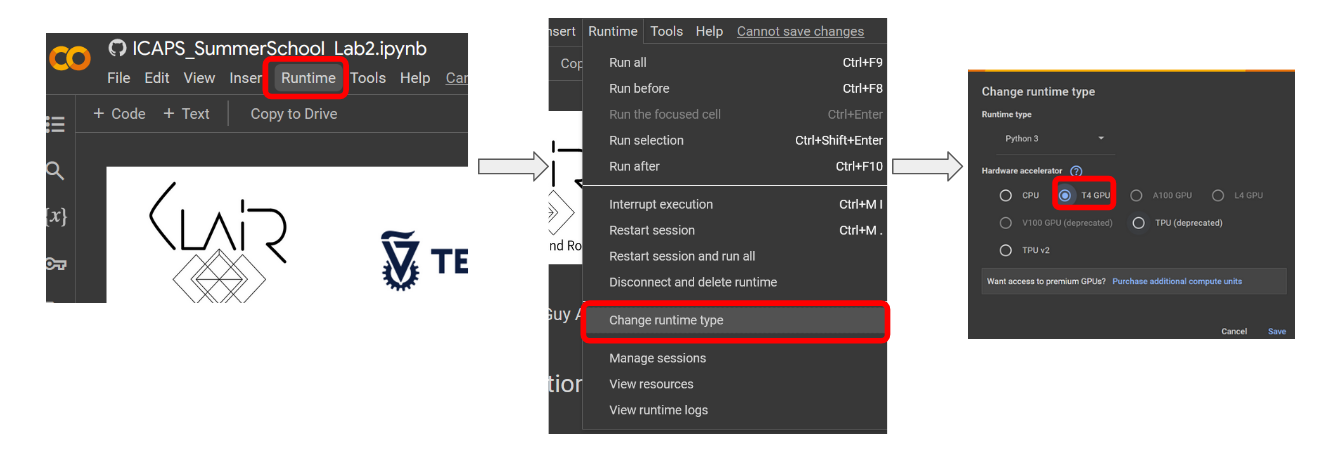

## Assignment Overview

For your first assignment, you will implement a pick-and-place task using Everything you learned (and will learn) in class. The goal is to pick up the red box and place it in the green bin without knocking over any obstacles. You will implement a full pipeline that includes control, motion planning, and perception.

You will implement the following components:
1. **PID Control**: Implement a PID controller to control the robot's end-effector position and orientation.
2. **Motion Planning During Manipulation**: Use a motion planning algorithm (e.g., RRT, PRM) to plan a path for the robot to pick up the red box and place it in the green bin while avoiding obstacles.
3. **Perception with Belief**: Utilize computer vision techniques to maintain a belief over the positions of the red box and green bin.
4. **Integration**: Integrate all components into a cohesive system that can perform the pick-and-place task in a simulated environment.

## Setup

In [1]:
# install required packages
!pip install mujoco
!pip install mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

# Enable GPU rendering in Colab
import os
import subprocess
from sys import stderr

try:
  is_gpu = not bool(subprocess.run('nvidia-smi').returncode)
except FileNotFoundError as e:
  is_gpu = False
if is_gpu:
  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)
else:
  print(
    'Cannot communicate with GPU.\n'
    'Make sure you are using a GPU Colab runtime.\n'
    'Go to the Runtime menu and select Choose runtime type.\n'
    'You can also skip this and use CPU with slower rendering.',
    file=stderr)
  
# Set the EGL backend for MuJoCo
import platform

is_apple_silicon = platform.system() == "Darwin" and platform.processor() == "arm"
if not is_apple_silicon:
  %env MUJOCO_GL=egl

Cannot communicate with GPU.
Make sure you are using a GPU Colab runtime.
Go to the Runtime menu and select Choose runtime type.
You can also skip this and use CPU with slower rendering.


## Our Working Environment

Our environment consists of our usual table, red box, and UR5e. However, there are a few modifications to make the task more challenging.
1. We have added a stationary green bin to serve as the target location for the red box.
2. We have introduced four movable obstacles on the table to increase the complexity of the motion planning task.
3. The UR5e robot has been equipped with a gripper to facilitate the pick-and-place operation.
4. The UR5e robot now uses velocity actuation instead of position actuation, making it harder to control

In [2]:
!git clone https://github.com/google-deepmind/mujoco_menagerie
(robot_path,) = !find mujoco_menagerie -name "ur5e.xml"
(gripper_path, _) = !find mujoco_menagerie -name "2f85.xml"
print(f"UR5e robot MJCF path: {robot_path}\n")
print(f"Gripper MJCF path: {gripper_path}\n")

xml = """
<mujoco model="tableworld">
    <statistic center="0.3 0 0.4" extent="0.8"/>

    <visual>
        <headlight diffuse="0.6 0.6 0.6" ambient="0.1 0.1 0.1" specular="0 0 0"/>
        <rgba haze="0.15 0.25 0.35 1"/>
        <global azimuth="45" elevation="-20"/>
    </visual>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="3072"/>
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3"
                 markrgb="0.8 0.8 0.8" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.2"/>
    </asset>

    <worldbody>
        <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
        <geom name="floor" pos="0.0 0.0 0.0" size="0 0 0.05" type="plane" material="groundplane"/>

        <body name="table" pos="0.3 0.0 0">
            <geom name="table_top" type="box" size=".37 .37 .01" pos="0 0 .7"/>
            <geom name="table_leg_1" type="cylinder" size=".01 .7" pos=".24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_2" type="cylinder" size=".01 .7" pos=".24 .24 -.0" euler="0 0 0"/>
            <geom name="table_leg_3" type="cylinder" size=".01 .7" pos="-.24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_4" type="cylinder" size=".01 .7" pos="-.24 .24 -.0" euler="0 0 0"/>
        </body>

        <body name="red_box" pos="0.3 -0.2 0.75">
            <freejoint/>
            <geom name="red_box_geom" type="box" size=".03 .03 .03" rgba="1 0 0 1"/>
        </body>
        <body name="green_bin" pos="0.45 0.25 0.71">
            <geom name="green_bin_bottom" type="box" size=".08 .08 .01" rgba="0 1 0 1"/>
            <geom name="green_bin_left_wall" type="box" size=".08 .01 .08" rgba="0 1 0 1" pos="0 -0.08 0.04"/>
            <geom name="green_bin_right_wall" type="box" size=".08 .01 .08" rgba="0 1 0 1" pos="0 0.08 0.04"/>
            <geom name="green_bin_back_wall" type="box" size=".01 .08 .08" rgba="0 1 0 1" pos="-0.08 0 0.04"/>
            <geom name="green_bin_front_wall" type="box" size=".01 .08 .08" rgba="0 1 0 1" pos="0.08 0 0.04"/>
        </body>

        <body name="obstacle1" pos="0.1 0.3 1.01">
            <freejoint/>
            <geom type="box" size=".025 .025 .3"  rgba="0 0 1 1"/>
        </body>
        <body name="obstacle2" pos="0.1 -0.3 1.01">
            <freejoint/>
            <geom type="box" size=".025 .025 .3"  rgba="0 0 1 1"/>
        </body>
        <body name="obstacle3" pos="0.55 0.05 1.01">
            <freejoint/>
            <geom type="box" size=".025 .025 .3"  rgba="0 0 1 1"/>
        </body>
        <body name="obstacle4" pos="0.3 0 0.81">
            <freejoint/>
            <geom type="box" size=".025 .025 .1"  rgba="0 0 1 1"/>
        </body>

        <!--angle view-->
        <camera name="rightangleview" pos="2.182 1.724 2.590" xyaxes="-0.685 0.729 0.000 -0.456 -0.429 0.780"/>
        <camera name="leftangleview" pos="2.182 -1.724 2.590" xyaxes="0.685 0.729 0.000 -0.456 0.429 0.780"/>
        <!-- front view -->
        <camera mode="fixed" name="frontview" pos="2.5 0 1.45" quat="0.56 0.43 0.43 0.56"/>
        <!-- bird view -->
        <camera mode="fixed" name="birdview" pos="0.3 0 3.0" quat="0.7071 0 0 0.7071"/>
        <!-- side view -->
        <camera mode="fixed" name="leftsideview" pos="0.151 -2.941 0.9" xyaxes="1.000 0.000 0.000 0.000 0.000 1.000"/>
        <camera mode="fixed" name="rightsideview" pos="0.151 2.941 0.9" xyaxes="-1.000 0.000 0.000 0.000 0.000 1.000"/>

    </worldbody>

</mujoco>
"""

import mujoco
import mediapy as media

scene_spec = mujoco.MjSpec.from_string(xml)
robot_spec = mujoco.MjSpec.from_file(robot_path)
gripper_spec = mujoco.MjSpec.from_file(gripper_path)

for act in robot_spec.actuators:
    act.gaintype = mujoco.mjtGain.mjGAIN_FIXED
    act.biastype = mujoco.mjtBias.mjBIAS_AFFINE
    act.gainprm = [2000.0] + [0.0]*9
    act.biasprm = [0.0, 0.0, -2000.0] + [0.0]*7  # makes it velocity control
robot_spec.key('home').ctrl = [0.0] * len(robot_spec.actuators)

# create a mount (body + site) in the parent where the robot should attach
mount = scene_spec.worldbody.add_body(name="mount", pos=[0.0, 0.0, 0.72], xyaxes=[0, -1, 0, 1, 0, 0])
mount_site = mount.add_site(name="mount_site", pos=[0, 0, 0])

# attach the entire robot spec to the parent's mount site (prefix renames attached elements)
scene_spec.attach(robot_spec, site=mount_site, prefix="robot_")

# attach the entire gripper spec to the robot's attachment site (prefix renames attached elements)
scene_spec.attach(gripper_spec, site="robot_attachment_site", prefix="gripper_")

# compile into a model and data
model = scene_spec.compile()
data = mujoco.MjData(model)

# Reset state and time to initial keyframe
mujoco.mj_resetDataKeyframe(model, data, model.key('robot_home').id)
# mujoco.mj_resetData(model, data)

duration= 1.0 # seconds
framerate = 60  # frames per second

frames = []
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="frontview")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

fatal: destination path 'mujoco_menagerie' already exists and is not an empty directory.
UR5e robot MJCF path: mujoco_menagerie/universal_robots_ur5e/ur5e.xml

Gripper MJCF path: mujoco_menagerie/robotiq_2f85_v4/2f85.xml



Already, we can see a major difficulty working with velocity actuation. In the above example, the robot has trouble holding its home configuration, even though we command the velocity to be zero. This is because of friction and other physical effects that cause the robot to drift over time, requiring a PID controller to maintain a desired position. For this, we will use a more sophisticated PID controller.

## Task 1: PID Control

In the previous tutorial, you implemented a proportional controller to control the end-effector position. There are two reasons why this isn't sufficient for our pick-and-place task:
1. We are going to use motion planning to navigate around obstacles, which means we will be working in configuration space rather than end-effector space.
2. We need to control both the position and orientation (A.K.A. **pose**) of the end-effector to successfully grasp

Therefore, we will be implementing our controller in configuration space. However, to get meaningful configurations, we must first implement an efficient method to translate between end-effector poses and robot configurations.

### Mapping Between Spaces

We would like to use the UR5e robot to manipulate objects in its workspace. For this, we need to place the end effector at specific coordinates and orientation within the workspace, i.e., the physical space where the robot interacts with objects. This task requires converting between the workspace and the C-space.

![forward and inverse kinematic](https://github.com/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/assets/figures/f_inv_kinematics.png?raw=true)

The process of mapping from a robot's configuration—specifically its joint angles—to the workspace—where the end effector's position and orientation are defined—is known as **forward kinematics**. This mapping is indeed feasible and relatively intuitive if we know the robot's geometric parameters, such as the lengths and relative positions of its links. The computation of the end effector's pose from the joint configurations is typically represented using matrix multiplications. These matrices, often referred to as transformation matrices, sequentially transform the pose from one joint to the next along the robot's arm, ultimately resulting in the pose of the end effector in the workspace.

As our tutorial on proportional control, we will bypass implementing forward kinematics for the UR5e robot using by getting the end effector's pose directly from the simulation environment:

In [46]:
from copy import deepcopy

def get_ee_pose(data: mujoco.MjData):
    attachment_site = data.site('robot_attachment_site')

    return deepcopy(attachment_site.xpos), deepcopy(attachment_site.xmat.reshape(3, 3))

**Inverse kinematics (IK)** involves determining the joint configurations that will achieve a specified position and orientation of the end effector in the workspace. This process is the reverse of forward kinematics and can be more complex because there may be multiple, or even an infinite number of, joint configurations that can result in the same end effector pose. IK essentially frames this challenge as an optimization problem, where the goal is to find the best set of joint angles that satisfy the end effector's target position and orientation. Unlike the direct calculations used in forward kinematics, solving inverse kinematics often requires the use of numerical methods and optimization techniques to find feasible solutions. However, there are analytical solutions for specific robots, including the UR5e, which can efficiently calculate exact joint angles for given end effector poses.

The `ur-analytic-ik` library provides an analytical solution for the inverse kinematics of the UR5e robot natively in python. Let's install it:

In [47]:
!pip install ur-analytic-ik

We will now implement a function to compute the inverse kinematics using this library:

In [48]:
from ur_analytic_ik import ur5e
import numpy as np

def compute_ik(target_pos, target_rot_mat):
    # ur-analytic-ik expects the end-effector pose in the robot's base frame.
    # The target_pos and target_quat are given in the world frame.
    # We need to account for the mount's translation and orientation if necessary.
    mount_body = model.body('mount')
    mount_pos, mount_quat = mount_body.pos, mount_body.quat
    
    # First, get the relative position
    rel_pos = target_pos - mount_pos

    # Convert mount quaternion to rotation matrix for inverse transform
    mount_rot_mat = np.empty(9)
    mujoco.mju_quat2Mat(mount_rot_mat, mount_quat)
    mount_rot_mat = mount_rot_mat.reshape(3, 3)

    # Apply inverse rotation to get position in mount frame
    target_pos = mount_rot_mat.T @ rel_pos

    # Compute relative rotation: R_relative = R_mount^T * R_target
    target_rot_mat = mount_rot_mat.T @ target_rot_mat

    # Compute IK solutions
    pose = np.identity(4)
    pose[:3, 3] = target_pos
    pose[:3, :3] = target_rot_mat
    ik_solutions = ur5e.inverse_kinematics(pose)

    return ik_solutions


Let's test it out. We will bring the robot to it's home configuration and get the end effector's pose. Then, we will use our `compute_ik` function to compute the joint angles that would bring the end effector to this pose and compare the results.

In [49]:
HOME_CONFIG = np.array([-1.5708, -1.5708,  1.5708, -1.5708, -1.5708,  0.])

mujoco.mj_resetDataKeyframe(model, data, model.key('robot_home').id)
# data.qpos[7:]  = HOME_CONFIG  # home configuration
mujoco.mj_forward(model, data)  # Update the simulation state
home_config_ee_pos, home_config_ee_rot = get_ee_pose(data)

sols = compute_ik(home_config_ee_pos, home_config_ee_rot)
sols

[array([-1.56937751, -1.07249489,  0.94007718,  1.70321038,  1.57080001,
        -3.14017016]),
 array([-1.56937751, -0.17319247, -0.94007718,  2.68406231,  1.57080001,
        -3.14017016]),
 array([-1.56937751e+00, -1.57011734e+00,  1.56986211e+00, -1.57054477e+00,
        -1.57080001e+00,  1.42249068e-03]),
 array([-1.56937751e+00, -8.04114299e-02, -1.56986211e+00,  7.94735500e-02,
        -1.57080001e+00,  1.42249068e-03]),
 array([ 2.10118787, -3.06118067,  1.56986152,  3.06211679,  1.5707913 ,
         0.53039522]),
 array([ 2.10118787, -1.57147531, -1.56986152, -1.57105084,  1.5707913 ,
         0.53039522]),
 array([ 2.10118787, -2.96840079,  0.94007792,  0.45752786, -1.5707913 ,
        -2.61119744]),
 array([ 2.10118787, -2.06909767, -0.94007792,  1.43838057, -1.5707913 ,
        -2.61119744])]

There are multiple solutions. Are all of them valid? Does any of them match the home configuration? To test this, let's visualize each solution in the simulator. First, we start by finding the correct indices for setting the `qpos` value in the data object:

In [ ]:
def get_entity_qpos_idx(model: mujoco.MjModel, prefix: str = "") -> list[int]:
    qpos_idx = []
    for i in range(model.njnt):
        joint = model.joint(i)
        if joint.name.startswith(prefix):
            qpos_idx.extend(range(joint.qposadr[0], joint.qposadr[0] + len(joint.qpos0)))
    return qpos_idx

Now let's visualize each IK solution one by one:

In [90]:
from ipywidgets import interact

robot_qpos_idx = get_entity_qpos_idx(model, "robot")

mujoco.mj_resetData(model, data)  # Reset state and time.

@interact(ik_solution_number=(0, len(sols)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(ik_solution_number, camera="leftsideview"):
    data.qpos[robot_qpos_idx] = sols[ik_solution_number]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())

interactive(children=(IntSlider(value=3, description='ik_solution_number', max=7), Dropdown(description='camer…

Let's repeat the above process to find a pose for grasping the red box from above:

In [91]:
pos = data.body('red_box').xpos + np.array([0, 0, 0.2])  # slightly above the box
rot_mat = np.array([[ 0, -1,  0],
                    [-1,  0,  0],
                    [ 0,  0, -1]])  # facing downward

box_ik_solutions = compute_ik(pos, rot_mat)

@interact(ik_solution_number=(0, len(box_ik_solutions)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(ik_solution_number, camera="leftsideview"):
    data.qpos[get_entity_qpos_idx(model, "robot") ] = box_ik_solutions[ik_solution_number]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())

interactive(children=(IntSlider(value=3, description='ik_solution_number', max=7), Dropdown(description='camer…

Let's select a solution with no collisions and implement a controller to bring the robot to this configuration.

In [53]:
above_box_config = box_ik_solutions[0]  # select one solution with no collisions

## Proportional Control for Velocity Actuation

We are now ready to implement our controller. First, let's implement the abstract policy class and rendering function as before:

In [77]:
from abc import ABC, abstractmethod


class Policy(ABC):
    """
    Abstract base class for control policies in MuJoCo.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
    """

    def __init__(self, model: mujoco.MjModel):
        self.model = model

    @abstractmethod
    def set_control(self, data: mujoco.MjData):
        """
        Set the control inputs for the actuators in the data object.
        Args:
            data (mujoco.MjData): The MuJoCo data object.
        """
        pass


def run_and_render_policy(model: mujoco.MjModel,
                          data: mujoco.MjData,
                          policy: Policy,
                          duration: float,
                          framerate: int,
                          camera: str = "frontview",
                          callback: callable = None):
    
    """
    Run a simulation with the given policy and render the result as a video.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
        data (mujoco.MjData): The MuJoCo data object.
        policy (Policy): The control policy to use.
        duration (float): The duration of the simulation in seconds.
        framerate (int): The framerate for rendering the video in Hz.
        camera (str): The name of the camera to use for rendering. defaults to "frontview".
    """
    mujoco.mj_resetData(model, data)  # Reset state and time.

    frames = []
    with mujoco.Renderer(model) as renderer:
        while data.time < duration:
            policy.set_control(data)

            mujoco.mj_step(model, data)

            if callback is not None:
                callback(model, data, policy)

            if len(frames) < data.time * framerate:
                renderer.update_scene(data, camera=camera)
                pixels = renderer.render()
                frames.append(pixels)
    
    if framerate > 0:
        media.show_video(frames, fps=framerate)

Now, let's bring over our implementation of the proportional controller from the previous tutorial and modify it to work in configuration space with velocity actuation.

Let's start with a helper function to find the indices of the robot's `ctrl` values:

In [78]:
def get_entity_ctrl_idx(model: mujoco.MjModel, prefix: str = "") -> list[int]:
    # Map actuators to their joint names, filter by prefix, return ctrl indices
    return [model.actuator(i).id for i in range(model.nu)
            if model.joint(model.actuator(i).trnid[0]).name.startswith(prefix)]

And now the controller itself.

**Hint**: It's actually more natural and intuitive to implement the controller in terms of joint velocities rather than end-effector velocities. Don't overthink it!

In [79]:
class ProportionalJointPositionControlPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, target_qpos: np.ndarray, kp: float):
        """
        A simple proportional controller in joint space.

        Args:
            model (mujoco.MjModel): MuJoCo model.
            target_qpos (np.ndarray): Target joint configuration (shape: [6] for UR5e).
            kp (float): Proportional gain.
        """
        super().__init__(model)
        self.target_qpos = target_qpos
        self.kp = kp

        self.qpos_idx = get_entity_qpos_idx(model, prefix="robot_")
        self.ctrl_idx = get_entity_ctrl_idx(model, prefix="robot_")

    def set_control(self, data: mujoco.MjData):
        """
        Compute joint position commands to drive the robot to the target configuration.
        """
        # Extract current UR5e joint positions (assuming last 6 are the arm joints)
        current_qpos = data.qpos[self.qpos_idx]

        # Compute configuration error
        q_error = self.target_qpos - current_qpos

        # Compute desired joint velocity (proportional term)
        qdot_desired = self.kp * q_error

        # Set control inputs (assuming velocity control)
        data.ctrl[self.ctrl_idx] = qdot_desired

Let's bring the robot to the home configuration and visualize the different solutions using different proportional gain values.

**NOTE**: We fully expect the robot to knock over the obstacles. That's okay! We will address this in the next task using motion planning.

In [80]:
from ipywidgets import interact
import numpy as np

@interact(kp=(0, 1000), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_proportional_control(kp=10, camera="frontview"):
    home_config_policy = ProportionalJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=kp
    )
    run_and_render_policy(model, data, home_config_policy, duration=2.0, framerate=60, camera=camera)

interactive(children=(IntSlider(value=10, description='kp', max=1000), Dropdown(description='camera', index=2,…

We can see that different gain values lead to different performance. On the one hand, we want to get to the target configuration quickly. Let's visualize this another way by plotting the distance to the target configuration over time for different gain values:

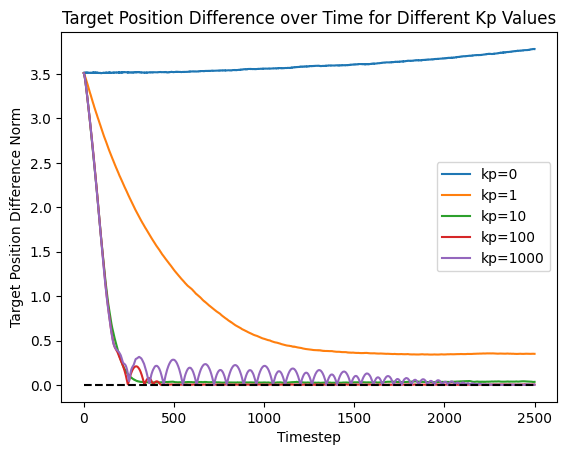

In [93]:
class TargetDiffCallback:
    def __init__(self):
        self.target_diffs = []

    def __call__(self, model, data, policy):
        # Store the relevant information in the target_diffs list
        target_diff = np.linalg.norm(data.qpos[policy.qpos_idx] - policy.target_qpos)
        self.target_diffs.append(target_diff)

import matplotlib.pyplot as plt

p_diffs_data = {}
for i in [0, 1, 10, 100, 1000]:
    cb = TargetDiffCallback()
    home_config_policy = ProportionalJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=i
    )

    # set framerate to 0 to skip rendering during data collection
    run_and_render_policy(model, data, home_config_policy, duration=5.0, framerate=0, callback=cb)
    p_diffs_data[i] = cb.target_diffs

for i in p_diffs_data:
    plt.plot(p_diffs_data[i], label=f'kp={i}')

plt.hlines(0, 0, len(p_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Kp Values')
plt.legend()
plt.show()

Note that for $kp=10$, the robot converges nicely toward the target, but seems to fall short. For $kp=1000$ The robot oscilates wildly around the target configuration. For $kp=100$, the robot converges very close to the target configuration, but with slight overshooting.

While $kp=100$ seems to be the best choice among the three, we cannot allow any overshooting so that our motion plan executions are safe. Overshooting means that the robot reaches the target at high speeds, which can lead to collisions with obstacles. So how can we fix this?

## PID Control

PID stands for Proportional-Integral-Derivative control. It is an extension of the proportional controller that we have already implemented. The idea is to add two more terms to the control signal to improve performance:
1. **Integral Term**: This term accounts for the accumulation of past errors. It helps eliminate steady-state errors that may occur with a pure proportional controller.
2. **Derivative Term**: This term predicts future errors based on the current rate of change of the error. It helps dampen the system's response and reduce overshooting.

We already know how to calculate the error term:
$$
e(t) = r - q(t)
$$
Where $r$ is the reference (target configuration) and $q(t)$ is the current configuration at time $t$.

The derivative of the error is calculated as follows:
$$
\frac{\partial}{\partial t} e(t)= \frac{\partial}{\partial t} (r - q(t)) = -\frac{\partial}{\partial t} q(t) = -v(t)
$$
Where $v(t)$ is the current joint velocities at time $t$.

The integral of the error is calculated as follows:
$$
\int_0^t e(\tau) d\tau \approx \sum_{i=0}^{n} e(t_i) \Delta t
$$

Let's start by getting the velocity indices for the robot. These are equivalent to the degrees of freedom for the UR5e robot:

In [81]:
def get_entity_qvel_idx(model: mujoco.MjModel, prefix: str = "") -> list[int]:
    return [model.joint(i).dofadr[0] for i in range(model.njnt) 
            if model.joint(i).name.startswith(prefix)]

Now, implement the PID controller:

In [215]:
from collections import deque

class PIDJointPositionControlPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, target_qpos: np.ndarray, kp: float, ki: float, kd: float, x=1000):
        """
        A PID controller in joint space for configuration control.

        Args:
            model (mujoco.MjModel): MuJoCo model.
            target_qpos (np.ndarray): Target joint configuration (shape: [6] for UR5e).
            kp (float): Proportional gain.
            ki (float): Integral gain.
            kd (float): Derivative gain.
        """
        super().__init__(model)
        self.target_qpos = target_qpos
        self.kp = kp
        self.ki = ki
        self.kd = kd

        # Initialize integral error accumulator
        self.integral_error = np.zeros_like(target_qpos)


        self.qpos_idx = get_entity_qpos_idx(model, prefix="robot_")
        self.qvel_idx = get_entity_qvel_idx(model, prefix="robot_")
        self.ctrl_idx = get_entity_ctrl_idx(model, prefix="robot_")

    def set_control(self, data: mujoco.MjData):
        """
        Compute joint position commands to drive the robot to the target configuration.
        """
        dt = self.model.opt.timestep

        # Get current joint positions and velocities (UR5e = last 6 joints)
        current_qpos = data.qpos[self.qpos_idx]
        current_qvel = data.qvel[self.qvel_idx]

        # Compute position error
        q_error = self.target_qpos - current_qpos

        # Update integral of error
        self.integral_error += q_error * dt

        # Compute derivative of error (can also use -current_qvel directly)
        q_error_dot = -current_qvel

        # PID control law (in velocity form)
        qdot_desired = (
            self.kp * q_error
            + self.ki * self.integral_error
            + self.kd * q_error_dot
        )

        # Set control inputs (assuming velocity control)
        data.ctrl[self.ctrl_idx] = qdot_desired


## Understanding PID Gains

The proportional gain is fairly straightforward: it is the proportion of the error that we use as the desired velocity. Now, let's understand the role of the derivative term and its gain.

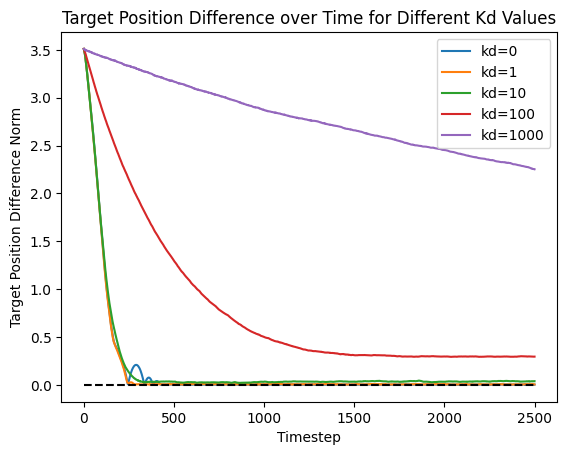

In [216]:
pd_diffs_data = {}
for i in [0, 1, 10, 100, 1000]:
    cb = TargetDiffCallback()
    home_config_policy = PIDJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=100, ki=0, kd=i
    )

    # set framerate to 0 to skip rendering during data collection
    run_and_render_policy(model, data, home_config_policy, duration=5.0, framerate=0, callback=cb)
    pd_diffs_data[i] = cb.target_diffs

for i in pd_diffs_data:
    plt.plot(pd_diffs_data[i], label=f'kd={i}')

plt.hlines(0, 0, len(pd_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Kd Values')
plt.legend()
plt.show()

The derivative term is a form of damping. It adds a velocity that is opposite to the current velocity, scaled by the derivative gain. This means that if the robot is moving quickly towards the target, the derivative term will apply a strong opposing velocity to slow it down. Conversely, if the robot is moving slowly, the opposing velocity will be smaller. Higher gains mean stronger damping effects.

With gain $kd=1$, The robot converges to the target, but not very smoothly. This is because the damping effect is too weak to counteract the momentum of the robot as it approaches the target configuration. With $kd=100$, the robot converges very smoothly but far from the target. This is because the damping effect is too strong, preventing the robot from reaching the target configuration effectively. With $kd=10$, we achieve a good balance: the robot converges to the target smoothly without overshooting. However, we can see that the robot is not quite reaching the target configuration.

Now let's understand the integral term and its gain.

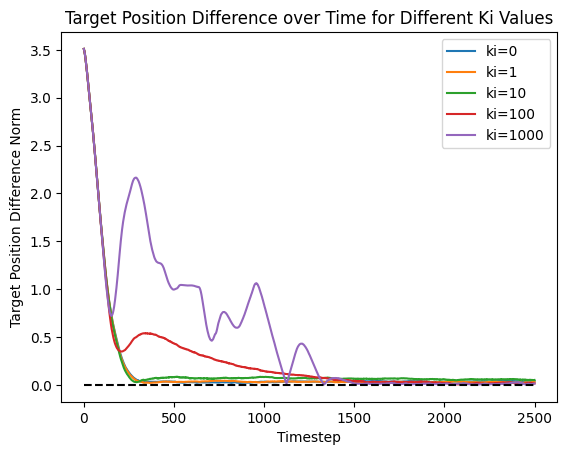

In [217]:
pid_diffs_data = {}
for i in [0, 1, 10, 100, 1000]:
    cb = TargetDiffCallback()
    home_config_policy = PIDJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=100, ki=i, kd=10, x=10
    )

    # set framerate to 0 to skip rendering during data collection
    run_and_render_policy(model, data, home_config_policy, duration=5.0, framerate=0, callback=cb)
    pid_diffs_data[i] = cb.target_diffs

for i in pid_diffs_data:
    plt.plot(pid_diffs_data[i], label=f'ki={i}')

plt.hlines(0, 0, len(pid_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Ki Values')
plt.legend()
plt.show()

The integral term helps eliminate steady-state errors. If the robot is consistently falling short of the target configuration, the integral term will accumulate this error over time and apply a velocity that pushes the robot closer to the target. Higher gains mean that the integral term will have a stronger effect on the control signal.

Let's compare the three controllers we have implemented so far: proportional, PD, and PID:

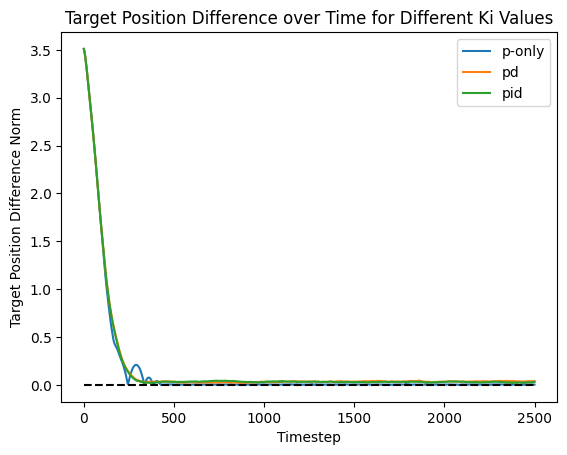

In [218]:
plt.plot(p_diffs_data[100], label='p-only')
plt.plot(pd_diffs_data[10], label='pd')
plt.plot(pid_diffs_data[1], label='pid')

plt.hlines(0, 0, len(pid_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Ki Values')
plt.legend()
plt.show()

We now have a well-functioning PID controller in configuration space using velocity actuation! It successfully brings us close to the target configuration without overshooting or getting stuck in a steady state before reaching the target. Though the difference between PD and PID controllers may seem subtle in this case, the integral term can be crucial in scenarios where persistent steady-state errors occur due to factors like friction or external disturbances. The integral component helps to correct these errors over time, ensuring that the system reaches and maintains the desired target configuration more accurately.

Let's test out our new PID controller by bringing the robot to the grasping configuration above the red box:

In [89]:
above_box_policy = PIDJointPositionControlPolicy(
    model, target_qpos=above_box_config,
    kp=100, ki=1, kd=10
)
run_and_render_policy(model, data, above_box_policy, duration=2.0, framerate=60)

## Task 2: Motion Planning during Manipulation

When performing a manipulation task, there are subtle nuances that we must consider when planning a path for the robot. In particular, we must consider that our standards for collision checking will change throughout execution.

Let's begin by bringing over our motion planner from the previous assignment. We will be using RRT-Connect as our motion planning algorithm.

In [21]:
#TODO: they need to implement OMPL motion planning for pick and place
# the key issue here is that the moving parts change when the robot grasps an object

## Task 3: Perception with Belief

In [22]:
#TODO: change where you get the box and bin pose. instead of using the model, use vision
# also need to estimate the uncertainty (Kalman filter).
# also need to estimate the object for EE grasping orientation